In [280]:
import pandas as pd
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import util

# Set up Spotify API Credentials

In [281]:
# Spotify developer page: https://developer.spotify.com/dashboard/applications/7085a21ce4124b3e89db61d750b133a7
client_id = '7085a21ce4124b3e89db61d750b133a7'
client_secret = '2b02da51f99f4470a1c2ef91f28a0957'

In [282]:
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API #chosen artist

# Clean Song Data
 - Remove bracketed phrases that mark verses + choruses in a song's lyrics
 - Remove non-alphaNumeric characters
 - Transform lyrics to lower-case
 - Remove stop-words
 - Lemmatize final lyrics

In [283]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [284]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

def remove_bracketed_measures(tmp):
#     start_find = ["[Intro","[Chorus", "[Verse", "[Pre-Chorus", "[Bridge"]
    start_find = ["["]
    for s in tqdm(start_find):
        while (tmp.find(s) != -1):
            firstDelPos= tmp.find(s) # get the position of [
#             chorusDelPos = tmp.find("[Chorus")
#             firstDelPos = verseDelPos if chorusDelPos==-1 else chorusDelPos if verseDelPos==-1 else verseDelPos if verseDelPos < chorusDelPos else chorusDelPos
            secondDelPos=tmp[firstDelPos:].find("]") + firstDelPos # get the position of ]
            if firstDelPos > secondDelPos:
                return tmp
            tmp = tmp.replace(tmp[firstDelPos:secondDelPos+1], "") # replace the string between two delimiters
    return tmp

def remove_nonalphanumeric(word):
    return " ".join([re.sub('[\W_]+', '', w) for w in word.split(' ')])

def remove_verse_workds(word):
    for remove_word in ['intro', 'verse', 'chorus', 'instrumental break']:
        word = " ".join([re.sub(remove_word, '', w) for w in word.split(' ')])
    return word

def remove_stop_words(doc):
    stop_words = set(stopwords.words('english')) 
    return ' '.join([w for w in doc.split(' ') if not w in stop_words])

def lower_case(doc):
    return doc.lower()

def clean_lyrics_data(song_data):
    song_data['lyrics_cleaned'] = song_data['lyrics'].apply(remove_bracketed_measures)
    song_data['lyrics_cleaned'] = song_data['lyrics_cleaned'].apply(lower_case)
    song_data['lyrics_cleaned'] = song_data['lyrics_cleaned'].apply(remove_nonalphanumeric)
    song_data['lyrics_cleaned'] = song_data['lyrics_cleaned'].apply(remove_stop_words)
    song_data['lyrics_clean_lemmatized'] = song_data['lyrics_cleaned'].apply(lemmatize_doc)
    song_data['lyrics_clean_stemmed'] = song_data['lyrics_cleaned'].apply(stem_doc)
    return song_data

def lemmatize_doc(doc):
    wordnet_lemmatizer = WordNetLemmatizer()
    return " ".join([wordnet_lemmatizer.lemmatize(word) for word in doc.split(" ")])

def stem_doc(doc):
    porter = PorterStemmer()
    return porter.stem(doc)

In [333]:
lyrics_data = pd.read_csv("master_lyrics_data.csv")

In [334]:
lyrics_data[lyrics_data.artist_name=='Alt-J']

accousticness                             album artist_name  \
164          0.679                           RELAXER       Alt-J   
165          0.736                           RELAXER       Alt-J   
166          0.726                           RELAXER       Alt-J   
167          0.740                           RELAXER       Alt-J   
168          0.734                           RELAXER       Alt-J   
..             ...                               ...         ...   
307          0.765  An Awesome Wave (Deluxe Version)       Alt-J   
308          0.882  An Awesome Wave (Deluxe Version)       Alt-J   
309          0.881  An Awesome Wave (Deluxe Version)       Alt-J   
310          0.968  An Awesome Wave (Deluxe Version)       Alt-J   
311          0.968  An Awesome Wave (Deluxe Version)       Alt-J   

     danceability  energy                      id  instrumentalness  liveness  \
164         0.634   0.139  5wYLW17fs9JOolzR2W3AmM           0.03600    0.0612   
165         0.635   0.138  5ong0qV1LTNeE4hAmRJM1b           0.02840    0.0652   
166         0.639   0.140  5JB1yuZjDoL0a4bq6fiqds           0.02770    0.0656   
167         0.637   0.137  6O1XKTvgVLwytNWdOlFcHI           0.02870    0.0655   
168         0.633   0.139  4LabjsmVYy7bI3F6oLIdLn           0.03080    0.0648   
..            ...     ...                     ...               ...       ...   
307         0.580   0.650  4j2j6RZXlLYOrMF6xMrKoL           0.37400    0.1130   
308         0.577   0.410  1GHMBn2IvBexQWAYWNY0kN           0.01360    0.0697   
309         0.419   0.404  54ntoEnAoJAH4rgs4GW3Wr           0.01250    0.0771   
310         0.336   0.125  0dFk7O3kP2khkmYbISvfpj           0.00848    0.1120   
311         0.382   0.122  21hJgeGuzJ9Fjv0YnYvc51           0.00951    0.1120   

     loudness                                             lyrics  popularity  \
164   -15.102  [Instrumental Intro]  [Verse 1: Gus Unger-Hami...        51.0   
165   -15.123  [Instrumental Intro]  [Verse 1: Gus Unger-Hami...        37.0   
166   -15.128  [Instrumental Intro]  [Verse 1: Gus Unger-Hami...        14.0   
167   -15.131  [Instrumental Intro]  [Verse 1: Gus Unger-Hami...        53.0   
168   -15.124  [Instrumental Intro]  [Verse 1: Gus Unger-Hami...         0.0   
..        ...                                                ...         ...   
307    -9.137  [Intro] This is from This is from This is from...        31.0   
308   -11.392  [Verse 1] We can't lose touch but we can let g...        12.0   
309   -11.394  [Verse 1] We can't lose touch but we can let g...        30.0   
310   -13.116  [Chorus] Your sting red-full-stops my skin Dot...        22.0   
311   -13.116  [Chorus] Your sting red-full-stops my skin Dot...        26.0   

     song_name                              song_uri  speechiness    tempo  \
164        3WW  spotify:track:5wYLW17fs9JOolzR2W3AmM       0.0533   78.053   
165        3WW  spotify:track:5ong0qV1LTNeE4hAmRJM1b       0.0524   78.040   
166        3WW  spotify:track:5JB1yuZjDoL0a4bq6fiqds       0.0522   78.083   
167        3WW  spotify:track:6O1XKTvgVLwytNWdOlFcHI       0.0519   78.017   
168        3WW  spotify:track:4LabjsmVYy7bI3F6oLIdLn       0.0529   78.195   
..         ...                                   ...          ...      ...   
307    Matilda  spotify:track:4j2j6RZXlLYOrMF6xMrKoL       0.0303  147.876   
308         Ms  spotify:track:1GHMBn2IvBexQWAYWNY0kN       0.0367  130.902   
309         Ms  spotify:track:54ntoEnAoJAH4rgs4GW3Wr       0.0393  130.952   
310  Hand-made  spotify:track:0dFk7O3kP2khkmYbISvfpj       0.0358  115.076   
311  Hand-Made  spotify:track:21hJgeGuzJ9Fjv0YnYvc51       0.0350  114.524   

     track_number                                   uri  valence  
164           1.0  spotify:track:5wYLW17fs9JOolzR2W3AmM   0.1580  
165           1.0  spotify:track:5ong0qV1LTNeE4hAmRJM1b   0.1460  
166           1.0  spotify:track:5JB1yuZjDoL0a4bq6fiqds   0.1490  
167           1.0  spotify:track:6O1XKTvgVLwytNWd

In [335]:
lyrics_data.shape

(212546, 18)

In [336]:
lyrics_data = lyrics_data[pd.notnull(lyrics_data.lyrics)]

In [338]:
lyrics_data.shape

(114526, 18)

In [339]:
lyrics.shape

(119287, 23)

In [291]:
lyrics = clean_lyrics_data(lyrics_data)

100%|██████████| 1/1 [00:00<00:00, 2993.79it/s]


100%|██████████| 1/1 [00:00<00:00, 3847.99it/s]


100%|██████████| 1/1 [00:00<00:00, 5433.04it/s]


100%|██████████| 1/1 [00:00<00:00, 864.27it/s]


100%|██████████| 1/1 [00:00<00:00, 1602.71it/s]


100%|██████████| 1/1 [00:00<00:00, 2779.53it/s]


100%|██████████| 1/1 [00:00<00:00, 5102.56it/s]


100%|██████████| 1/1 [00:00<00:00, 2487.72it/s]


100%|██████████| 1/1 [00:00<00:00, 366.57it/s]


100%|██████████| 1/1 [00:00<00:00, 4877.10it/s]


100%|██████████| 1/1 [00:00<00:00, 3355.44it/s]


100%|██████████| 1/1 [00:00<00:00, 1475.31it/s]


100%|██████████| 1/1 [00:00<00:00, 1303.79it/s]


100%|██████████| 1/1 [00:00<00:00, 4466.78it/s]


100%|██████████| 1/1 [00:00<00:00, 5745.62it/s]


100%|██████████| 1/1 [00:00<00:00, 820.96it/s]


100%|██████████| 1/1 [00:00<00:00, 1562.12it/s]


100%|██████████| 1/1 [00:00<00:00, 3584.88it/s]


100%|██████████| 1/1 [00:00<00:00, 4854.52it/s]


100%|██████████| 1/1 [00:00<00:00, 4132.32it/s]


100%|██████████| 1/1 [00:00<00:00, 1524.09it/s]


100%|██████████| 1/1 [00:00<00:00, 4096.00it/s]


100%|██████████| 1/1 [00:00<00:00, 3266.59it/s]


100%|██████████| 1/1 [00:00<00:00, 869.65it/s]


100%|██████████| 1/1 [00:00<00:00, 4485.89it/s]


100%|██████████| 1/1 [00:00<00:00, 3744.91it/s]


100%|██████████| 1/1 [00:00<00:00, 5262.61it/s]


100%|██████████| 1/1 [00:00<00:00, 3030.57it/s]


100%|██████████| 1/1 [00:00<00:00, 3923.58it/s]


100%|██████████| 1/1 [00:00<00:00, 4696.87it/s]


100%|██████████| 1/1 [00:00<00:00, 868.75it/s]


100%|██████████| 1/1 [00:00<00:00, 2896.62it/s]


100%|██████████| 1/1 [00:00<00:00, 5178.15it/s]


100%|██████████| 1/1 [00:00<00:00, 2083.61it/s]


100%|██████████| 1/1 [00:00<00:00, 1034.10it/s]


100%|██████████| 1/1 [00:00<00:00, 5322.72it/s]


100%|██████████| 1/1 [00:00<00:00, 6288.31it/s]


100%|██████████| 1/1 [00:00<00:00, 3905.31it/s]


100%|██████████| 1/1 [00:00<00:00, 2814.97it/s]


100%|██████████| 1/1 [00:00<00:00, 616.54it/s]


100%|██████████| 1/1 [00:00<00:00, 5184.55it/s]


100%|██████████| 1/1 [00:00<00:00, 5614.86it/s]


100%|██████████| 1/1 [00:00<00:00, 1173.56it/s]

100%|██████████| 1/1 [00:00<00:00, 6096.37it/s]


100%|██████████| 1/1 [00:00<00:00, 2725.34it/s]


100%|██████████| 1/1 [00:00<00:00, 669.38it/s]


100%|██████████| 1/1 [00:00<00:00, 3930.93it/s]


100%|██████████| 1/1 [00:00<00:00, 5377.31it/s]

100%|██████████| 1/1 [00:00<00:00, 2007.80it/s]


100%|██████████| 1/1 [00:00<00:00, 1392.53it/s]


100%|██████████| 1/1 [00:00<00:00, 890.70it/s]


100%|██████████| 1/1 [00:00<00:00, 3560.53it/s]


100%|██████████| 1/1 [00:00<00:00, 3472.11it/s]


100%|██████████| 1/1 [00:00<00:00, 1510.37it/s]


100%|██████████| 1/1 [00:00<00:00, 2711.25it/s]


100%|██████████| 1/1 [00:00<00:00, 1239.45it/s]


100%|██████████| 1/1 [00:00<00:00, 5262.61it/s]


100%|██████████| 1/1 [00:00<00:00, 1960.87it/s]


100%|██████████| 1/1 [00:00<00:00, 2025.26it/s]


100%|██████████| 1/1 [00:00<00:00, 3799.19it/s]


100%|██████████| 1/1 [00:00<00:00, 965.32it/s]


100%|██████████| 1/1 [00:00<00:00, 3236.35it/s]


100%|██████████| 1/1 [00:00<00:00, 2674.94it/s]


100%|██████████| 1/1 [00:00<00:00, 3872.86it/s]


100%|██████████| 1/1 [00:00<00:00, 3625.15it/s]


100%|██████████| 1/1 [00:00<00:00, 5152.71it/s]


100%|██████████| 1/1 [00:00<00:00, 2258.65it/s]


100%|██████████| 1/1 [00:00<00:00, 1730.32it/s]


100%|██████████| 1/1 [00:00<00:00, 5315.97it/s]


100%|██████████| 1/1 [00:00<00:00, 3134.76it/s]


100%|██████████| 1/1 [00:00<00:00, 5370.43it/s]


100%|██████████| 1/1 [00:00<00:00, 6765.01it/s]


100%|██████████| 1/1 [00:00<00:00, 4466.78it/s]


100%|██████████| 1/1 [00:00<00:00, 826.30it/s]


100%|██████████| 1/1 [00:00<00:00, 6250.83it/s]


100%|██████████| 1/1 [00:00<00:00, 1535.81it/s]


100%|██████████| 1/1 [00:00<00:00, 1254.65it/s]


100%|██████████| 1/1 [00:00<00:00, 3379.78it/s]


100%|██████████| 1/1 [00:00<00:00, 5377.31it/s]


100%|██████████| 1/1 [00:00<00:00, 680.78it/s]


100%|██████████| 1/1 [00:00<00:00, 1019.27it/s]


100%|██████████| 1/1 [00:00<00:00, 3672.77it/s]


100%|██████████| 1/1 [00:00<00:00, 5691.05it/s]


100%|██████████| 1/1 [00:00<00:00, 2403.61it/s]


100%|██████████| 1/1 [00:00<00:00, 2062.10it/s]


100%|██████████| 1/1 [00:00<00:00, 5184.55it/s]


100%|██████████| 1/1 [00:00<00:00, 3279.36it/s]


100%|██████████| 1/1 [00:00<00:00, 4236.67it/s]


100%|██████████| 1/1 [00:00<00:00, 5555.37it/s]


100%|██████████| 1/1 [00:00<00:00, 3088.59it/s]


100%|██████████| 1/1 [00:00<00:00, 1368.01it/s]


100%|██████████| 1/1 [00:00<00:00, 1011.16it/s]


100%|██████████| 1/1 [00:00<00:00, 5882.61it/s]


100%|██████████| 1/1 [00:00<00:00, 4391.94it/s]


100%|██████████| 1/1 [00:00<00:00, 1562.71it/s]


100%|██████████| 1/1 [00:00<00:00, 4144.57it/s]


100%|██████████| 1/1 [00:00<00:00, 2462.89it/s]


100%|██████████| 1/1 [00:00<00:00, 4148.67it/s]


100%|██████████| 1/1 [00:00<00:00, 1852.61it/s]


100%|██████████| 1/1 [00:00<00:00, 5384.22it/s]


100%|██████████| 1/1 [00:00<00:00, 3423.92it/s]


100%|██████████| 1/1 [00:00<00:00, 2644.58it/s]


100%|██████████| 1/1 [00:00<00:00, 5315.97it/s]


100%|██████████| 1/1 [00:00<00:00, 5071.71it/s]


100%|██████████| 1/1 [00:00<00:00, 2145.42it/s]


100%|██████████| 1/1 [00:00<00:00, 3050.40it/s]


100%|██████████| 1/1 [00:00<00:00, 4084.04it/s]

100%|██████████| 1/1 [00:00<00:00, 2584.29it/s]


100%|██████████| 1/1 [00:00<00:00, 1557.48it/s]


100%|██████████| 1/1 [00:00<00:00, 1987.82it/s]


100%|██████████| 1/1 [00:00<00:00, 4871.43it/s]

100%|██████████| 1/1 [00:00<00:00, 3236.35it/s]


100%|██████████| 1/1 [00:00<00:00, 4760.84it/s]


100%|██████████| 1/1 [00:00<00:00, 3104.59it/s]


100%|██████████| 1/1 [00:00<00:00, 3701.95it/s]


100%|██████████| 1/1 [00:00<00:00, 2631.31it/s]


100%|██████████| 1/1 [00:00<00:00, 4328.49it/s]


100%|██████████| 1/1 [00:00<00:00, 3258.98it/s]


100%|██████████| 1/1 [00:00<00:00, 1107.55it/s]


100%|██████████| 1/1 [00:00<00:00, 4443.12it/s]


100%|██████████| 1/1 [00:00<00:00, 1697.41it/s]


100%|██████████| 1/1 [00:00<00:00, 4306.27it/s]


100%|██████████| 1/1 [00:00<00:00, 3819.95it/s]


100%|██████████| 1/1 [00:00<00:00, 4969.55it/s]


100%|██████████| 1/1 [00:00<00:00, 2711.25it/s]


100%|██████████| 1/1 [00:00<00:00, 2232.20it/s]


100%|██████████| 1/1 [00:00<00:00, 898.52it/s]


100%|██████████| 1/1 [00:00<00:00, 1246.82it/s]

100%|██████████| 1/1 [00:00<00:00, 2487.72it/s]


100%|██████████| 1/1 [00:00<00:00, 788.11it/s]


100%|██████████| 1/1 [00:00<00:00, 1975.65it/s]


100%|██████████| 1/1 [00:00<00:00, 1236.16it/s]


100%|██████████| 1/1 [00:00<00:00, 1407.96it/s]


100%|██████████| 1/1 [00:00<00:00, 5874.38it/s]


100%|██████████| 1/1 [00:00<00:00, 1655.21it/s]


100%|██████████| 1/1 [00:00<00:00, 4593.98it/s]


100%|██████████| 1/1 [00:00<00:00, 4198.50it/s]


100%|██████████| 1/1 [00:00<00:00, 4169.29it/s]


100%|██████████| 1/1 [00:00<00:00, 4782.56it/s]


100%|██████████| 1/1 [00:00<00:00, 1119.68it/s]


100%|██████████| 1/1 [00:00<00:00, 1766.77it/s]


100%|██████████| 1/1 [00:00<00:00, 5691.05it/s]


100%|██████████| 1/1 [00:00<00:00, 1424.70it/s]


100%|██████████| 1/1 [00:00<00:00, 3423.92it/s]


100%|██████████| 1/1 [00:00<00:00, 3269.14it/s]


100%|██████████| 1/1 [00:00<00:00, 1901.32it/s]


100%|██████████| 1/1 [00:00<00:00, 2240.55it/s]


100%|██████████| 1/1 [00:00<00:00, 1108.43it/s]


100%|██████████| 1/1 [00:00<00:00, 3151.24it/s]


100%|██████████| 1/1 [00:00<00:00, 3816.47it/s]


100%|██████████| 1/1 [00:00<00:00, 2888.64it/s]


100%|██████████| 1/1 [00:00<00:00, 3634.58it/s]


100%|██████████| 1/1 [00:00<00:00, 3688.92it/s]


100%|██████████| 1/1 [00:00<00:00, 4604.07it/s]


100%|██████████| 1/1 [00:00<00:00, 669.38it/s]


100%|██████████| 1/1 [00:00<00:00, 3650.40it/s]


100%|██████████| 1/1 [00:00<00:00, 3344.74it/s]


100%|██████████| 1/1 [00:00<00:00, 6213.78it/s]


100%|██████████| 1/1 [00:00<00:00, 2801.81it/s]


100%|██████████| 1/1 [00:00<00:00, 2914.74it/s]


100%|██████████| 1/1 [00:00<00:00, 2924.90it/s]


100%|██████████| 1/1 [00:00<00:00, 3802.63it/s]


100%|██████████| 1/1 [00:00<00:00, 2746.76it/s]


100%|██████████| 1/1 [00:00<00:00, 2262.30it/s]


100%|██████████| 1/1 [00:00<00:00, 3718.35it/s]


100%|██████████| 1/1 [00:00<00:00, 3597.17it/s]


100%|██████████| 1/1 [00:00<00:00, 3446.43it/s]


100%|██████████| 1/1 [00:00<00:00, 3788.89it/s]


100%|██████████| 1/1 [00:00<00:00, 2543.54it/s]


100%|██████████| 1/1 [00:00<00:00, 2247.75it/s]


100%|██████████| 1/1 [00:00<00:00, 4629.47it/s]


100%|██████████| 1/1 [00:00<00:00, 2623.08it/s]


100%|██████████| 1/1 [00:00<00:00, 1721.09it/s]


100%|██████████| 1/1 [00:00<00:00, 2666.44it/s]


100%|██████████| 1/1 [00:00<00:00, 4826.59it/s]


100%|██████████| 1/1 [00:00<00:00, 6017.65it/s]


100%|██████████| 1/1 [00:00<00:00, 3019.66it/s]


100%|██████████| 1/1 [00:00<00:00, 1903.91it/s]

100%|██████████| 1/1 [00:00<00:00, 4017.53it/s]


100%|██████████| 1/1 [00:00<00:00, 3344.74it/s]


100%|██████████| 1/1 [00:00<00:00, 5907.47it/s]


100%|██████████| 1/1 [00:00<00:00, 4614.20it/s]


100%|██████████| 1/1 [00:00<00:00, 2799.94it/s]


100%|██████████| 1/1 [00:00<00:00, 5152.71it/s]


100%|██████████| 1/1 [00:00<00:00, 862.14it/s]


100%|██████████| 1/1 [00:00<00:00, 2212.19it/s]


100%|██████████| 1/1 [00:00<00:00, 3206.65it/s]


100%|██████████| 1/1 [00:00<00:00, 651.09it/s]


100%|██████████| 1/1 [00:00<00:00, 1923.11it/s]


100%|██████████| 1/1 [00:00<00:00, 5023.12it/s]


100%|██████████| 1/1 [00:00<00:00, 5262.61it/s]


100%|██████████| 1/1 [00:00<00:00, 860.72it/s]


100%|██████████| 1/1 [00:00<00:00, 2631.31it/s]


100%|██████████| 1/1 [00:00<00:00, 1298.55it/s]


100%|██████████| 1/1 [00:00<00:00, 1293.74it/s]


100%|██████████| 1/1 [00:00<00:00, 4332.96it/s]


100%|██████████| 1/1 [00:00<00:00, 3731.59it/s]


100%|██████████| 1/1 [00:00<00:00, 5053.38it/s]


100%|██████████| 1/1 [00:00<00:00, 752.88it/s]


100%|██████████| 1/1 [00:00<00:00, 3184.74it/s]


100%|██████████| 1/1 [00:00<00:00, 5675.65it/s]


100%|██████████| 1/1 [00:00<00:00, 5152.71it/s]


100%|██████████| 1/1 [00:00<00:00, 1052.79it/s]


100%|██████████| 1/1 [00:00<00:00, 621.10it/s]


100%|██████████| 1/1 [00:00<00:00, 1968.23it/s]


100%|██████████| 1/1 [00:00<00:00, 1730.32it/s]


100%|██████████| 1/1 [00:00<00:00, 3744.91it/s]


100%|██████████| 1/1 [00:00<00:00, 4271.19it/s]


100%|██████████| 1/1 [00:00<00:00, 3806.08it/s]


100%|██████████| 1/1 [00:00<00:00, 3182.32it/s]


100%|██████████| 1/1 [00:00<00:00, 1162.82it/s]


100%|██████████| 1/1 [00:00<00:00, 4568.96it/s]


100%|██████████| 1/1 [00:00<00:00, 1565.04it/s]


100%|██████████| 1/1 [00:00<00:00, 5127.51it/s]


100%|██████████| 1/1 [00:00<00:00, 458.09it/s]


100%|██████████| 1/1 [00:00<00:00, 3625.15it/s]


100%|██████████| 1/1 [00:00<00:00, 2499.59it/s]


100%|██████████| 1/1 [00:00<00:00, 2232.20it/s]


100%|██████████| 1/1 [00:00<00:00, 1594.79it/s]


100%|██████████| 1/1 [00:00<00:00, 3236.35it/s]


100%|██████████| 1/1 [00:00<00:00, 4328.49it/s]


100%|██████████| 1/1 [00:00<00:00, 1161.54it/s]


100%|██████████| 1/1 [00:00<00:00, 815.70it/s]


100%|██████████| 1/1 [00:00<00:00, 884.87it/s]


100%|██████████| 1/1 [00:00<00:00, 4696.87it/s]


100%|██████████| 1/1 [00:00<00:00, 1852.61it/s]


100%|██████████| 1/1 [00:00<00:00, 4524.60it/s]

100%|██████████| 1/1 [00:00<00:00, 3446.43it/s]


100%|██████████| 1/1 [00:00<00:00, 3983.19it/s]


100%|██████████| 1/1 [00:00<00:00, 2283.24it/s]


100%|██████████| 1/1 [00:00<00:00, 2864.96it/s]


100%|██████████| 1/1 [00:00<00:00, 3355.44it/s]


100%|██████████| 1/1 [00:00<00:00, 2141.04it/s]


100%|██████████| 1/1 [00:00<00:00, 1269.08it/s]


100%|██████████| 1/1 [00:00<00:00, 2775.85it/s]


100%|██████████| 1/1 [00:00<00:00, 5405.03it/s]


100%|██████████| 1/1 [00:00<00:00, 6710.89it/s]


100%|██████████| 1/1 [00:00<00:00, 4766.25it/s]


100%|██████████| 1/1 [00:00<00:00, 5584.96it/s]


100%|██████████| 1/1 [00:00<00:00, 2222.74it/s]


100%|██████████| 1/1 [00:00<00:00, 1168.33it/s]


100%|██████████| 1/1 [00:00<00:00, 4877.10it/s]


100%|██████████| 1/1 [00:00<00:00, 1153.87it/s]


100%|██████████| 1/1 [00:00<00:00, 5584.96it/s]


100%|██████████| 1/1 [00:00<00:00, 3472.11it/s]


100%|██████████| 1/1 [00:00<00:00, 2392.64it/s]


100%|██████████| 1/1 [00:00<00:00, 5526.09it/s]

100%|██████████| 1/1 [00:00<00:00, 2457.12it/s]


100%|██████████| 1/1 [00:00<00:00, 1880.01it/s]

100%|██████████| 1/1 [00:00<00:00, 5714.31it/s]


100%|██████████| 1/1 [00:00<00:00, 3474.98it/s]


100%|██████████| 1/1 [00:00<00:00, 4804.47it/s]


100%|██████████| 1/1 [00:00<00:00, 1686.49it/s]


100%|██████████| 1/1 [00:00<00:00, 4999.17it/s]


100%|██████████| 1/1 [00:00<00:00, 4169.29it/s]


100%|██████████| 1/1 [00:00<00:00, 1505.49it/s]


100%|██████████| 1/1 [00:00<00:00, 2768.52it/s]


100%|██████████| 1/1 [00:00<00:00, 5433.04it/s]


100%|██████████| 1/1 [00:00<00:00, 5584.96it/s]


100%|██████████| 1/1 [00:00<00:00, 1204.91it/s]


100%|██████████| 1/1 [00:00<00:00, 1079.89it/s]


100%|██████████| 1/1 [00:00<00:00, 5029.14it/s]


100%|██████████| 1/1 [00:00<00:00, 988.29it/s]


100%|██████████| 1/1 [00:00<00:00, 4837.72it/s]


100%|██████████| 1/1 [00:00<00:00, 2857.16it/s]


100%|██████████| 1/1 [00:00<00:00, 1791.67it/s]


100%|██████████| 1/1 [00:00<00:00, 2438.55it/s]


100%|██████████| 1/1 [00:00<00:00, 3194.44it/s]


100%|██████████| 1/1 [00:00<00:00, 6034.97it/s]


100%|██████████| 1/1 [00:00<00:00, 1750.54it/s]


100%|██████████| 1/1 [00:00<00:00, 1636.48it/s]


100%|██████████| 1/1 [00:00<00:00, 622.21it/s]


100%|██████████| 1/1 [00:00<00:00, 1075.19it/s]


100%|██████████| 1/1 [00:00<00:00, 6168.09it/s]

100%|██████████| 1/1 [00:00<00:00, 1657.83it/s]


100%|██████████| 1/1 [00:00<00:00, 2101.35it/s]


100%|██████████| 1/1 [00:00<00:00, 3637.73it/s]


100%|██████████| 1/1 [00:00<00:00, 1934.64it/s]


100%|██████████| 1/1 [00:00<00:00, 858.43it/s]


100%|██████████| 1/1 [00:00<00:00, 3194.44it/s]


100%|██████████| 1/1 [00:00<00:00, 4609.13it/s]


100%|██████████| 1/1 [00:00<00:00, 3379.78it/s]


100%|██████████| 1/1 [00:00<00:00, 4236.67it/s]


100%|██████████| 1/1 [00:00<00:00, 1917.83it/s]


100%|██████████| 1/1 [00:00<00:00, 2021.35it/s]


100%|██████████| 1/1 [00:00<00:00, 3775.25it/s]


100%|██████████| 1/1 [00:00<00:00, 3530.56it/s]


100%|██████████| 1/1 [00:00<00:00, 2434.30it/s]


100%|██████████| 1/1 [00:00<00:00, 1969.16it/s]

100%|██████████| 1/1 [00:00<00:00, 3584.88it/s]


100%|██████████| 1/1 [00:00<00:00, 2048.00it/s]


100%|██████████| 1/1 [00:00<00:00, 3813.00it/s]


100%|██████████| 1/1 [00:00<00:00, 4029.11it/s]

100%|██████████| 1/1 [00:00<00:00, 3908.95it/s]


100%|██████████| 1/1 [00:00<00:00, 3302.60it/s]


100%|██████████| 1/1 [00:00<00:00, 4777.11it/s]


100%|██████████| 1/1 [00:00<00:00, 1597.22it/s]


100%|██████████| 1/1 [00:00<00:00, 1233.26it/s]


100%|██████████| 1/1 [00:00<00:00, 4452.55it/s]


100%|██████████| 1/1 [00:00<00:00, 3923.58it/s]


100%|██████████| 1/1 [00:00<00:00, 1503.33it/s]


100%|██████████| 1/1 [00:00<00:00, 4877.10it/s]


100%|██████████| 1/1 [00:00<00:00, 1589.96it/s]


100%|██████████| 1/1 [00:00<00:00, 3269.14it/s]


100%|██████████| 1/1 [00:00<00:00, 4288.65it/s]


100%|██████████| 1/1 [00:00<00:00, 2811.20it/s]


100%|██████████| 1/1 [00:00<00:00, 2892.62it/s]


100%|██████████| 1/1 [00:00<00:00, 3521.67it/s]


100%|██████████| 1/1 [00:00<00:00, 3572.66it/s]


100%|██████████| 1/1 [00:00<00:00, 3095.43it/s]


100%|██████████| 1/1 [00:00<00:00, 1711.96it/s]


100%|██████████| 1/1 [00:00<00:00, 4760.84it/s]


100%|██████████| 1/1 [00:00<00:00, 1053.85it/s]


100%|██████████| 1/1 [00:00<00:00, 1436.90it/s]


100%|██████████| 1/1 [00:00<00:00, 3509.88it/s]


100%|██████████| 1/1 [00:00<00:00, 5497.12it/s]


100%|██████████| 1/1 [00:00<00:00, 1453.33it/s]


100%|██████████| 1/1 [00:00<00:00, 1252.78it/s]


100%|██████████| 1/1 [00:00<00:00, 4609.13it/s]


100%|██████████| 1/1 [00:00<00:00, 1265.63it/s]


100%|██████████| 1/1 [00:00<00:00, 4760.84it/s]


100%|██████████| 1/1 [00:00<00:00, 2364.32it/s]


100%|██████████| 1/1 [00:00<00:00, 1338.75it/s]


100%|██████████| 1/1 [00:00<00:00, 4096.00it/s]


100%|██████████| 1/1 [00:00<00:00, 2348.43it/s]


100%|██████████| 1/1 [00:00<00:00, 1733.18it/s]


100%|██████████| 1/1 [00:00<00:00, 1851.79it/s]


100%|██████████| 1/1 [00:00<00:00, 475.98it/s]


100%|██████████| 1/1 [00:00<00:00, 1230.36it/s]


100%|██████████| 1/1 [00:00<00:00, 4568.96it/s]


100%|██████████| 1/1 [00:00<00:00, 1831.57it/s]


100%|██████████| 1/1 [00:00<00:00, 3905.31it/s]


100%|██████████| 1/1 [00:00<00:00, 4544.21it/s]

100%|██████████| 1/1 [00:00<00:00, 3705.22it/s]


100%|██████████| 1/1 [00:00<00:00, 5652.70it/s]


100%|██████████| 1/1 [00:00<00:00, 2949.58it/s]


100%|██████████| 1/1 [00:00<00:00, 4563.99it/s]


100%|██████████| 1/1 [00:00<00:00, 1560.38it/s]


100%|██████████| 1/1 [00:00<00:00, 4116.10it/s]


100%|██████████| 1/1 [00:00<00:00, 1468.59it/s]


100%|██████████| 1/1 [00:00<00:00, 1969.16it/s]


100%|██████████| 1/1 [00:00<00:00, 1513.10it/s]


100%|██████████| 1/1 [00:00<00:00, 4588.95it/s]


100%|██████████| 1/1 [00:00<00:00, 4181.76it/s]


100%|██████████| 1/1 [00:00<00:00, 4993.22it/s]


100%|██████████| 1/1 [00:00<00:00, 4424.37it/s]


100%|██████████| 1/1 [00:00<00:00, 2150.93it/s]


100%|██████████| 1/1 [00:00<00:00, 3715.06it/s]


100%|██████████| 1/1 [00:00<00:00, 2966.27it/s]


100%|██████████| 1/1 [00:00<00:00, 577.33it/s]


100%|██████████| 1/1 [00:00<00:00, 264.06it/s]


100%|██████████| 1/1 [00:00<00:00, 3088.59it/s]


100%|██████████| 1/1 [00:00<00:00, 3289.65it/s]


100%|██████████| 1/1 [00:00<00:00, 3415.56it/s]


100%|██████████| 1/1 [00:00<00:00, 3692.17it/s]


100%|██████████| 1/1 [00:00<00:00, 2576.35it/s]


100%|██████████| 1/1 [00:00<00:00, 3048.19it/s]


100%|██████████| 1/1 [00:00<00:00, 3002.37it/s]


100%|██████████| 1/1 [00:00<00:00, 2551.28it/s]


100%|██████████| 1/1 [00:00<00:00, 3030.57it/s]


100%|██████████| 1/1 [00:00<00:00, 2976.79it/s]


100%|██████████| 1/1 [00:00<00:00, 3116.12it/s]


100%|██████████| 1/1 [00:00<00:00, 3125.41it/s]


100%|██████████| 1/1 [00:00<00:00, 2045.00it/s]


100%|██████████| 1/1 [00:00<00:00, 3483.64it/s]


100%|██████████| 1/1 [00:00<00:00, 1960.87it/s]


100%|██████████| 1/1 [00:00<00:00, 3560.53it/s]


100%|██████████| 1/1 [00:00<00:00, 927.12it/s]


100%|██████████| 1/1 [00:00<00:00, 4096.00it/s]


100%|██████████| 1/1 [00:00<00:00, 3310.42it/s]


100%|██████████| 1/1 [00:00<00:00, 4405.78it/s]


100%|██████████| 1/1 [00:00<00:00, 2707.75it/s]


100%|██████████| 1/1 [00:00<00:00, 4350.94it/s]


100%|██████████| 1/1 [00:00<00:00, 4032.98it/s]


100%|██████████| 1/1 [00:00<00:00, 3813.00it/s]


100%|██████████| 1/1 [00:00<00:00, 5023.12it/s]


100%|██████████| 1/1 [00:00<00:00, 3998.38it/s]


100%|██████████| 1/1 [00:00<00:00, 3412.78it/s]


100%|██████████| 1/1 [00:00<00:00, 3184.74it/s]


100%|██████████| 1/1 [00:00<00:00, 3799.19it/s]


100%|██████████| 1/1 [00:00<00:00, 2071.26it/s]


100%|██████████| 1/1 [00:00<00:00, 3144.16it/s]


100%|██████████| 1/1 [00:00<00:00, 3297.41it/s]


100%|██████████| 1/1 [00:00<00:00, 3390.71it/s]


100%|██████████| 1/1 [00:00<00:00, 3844.46it/s]


100%|██████████| 1/1 [00:00<00:00, 4202.71it/s]


100%|██████████| 1/1 [00:00<00:00, 739.08it/s]


100%|██████████| 1/1 [00:00<00:00, 1167.35it/s]


100%|██████████| 1/1 [00:00<00:00, 2044.01it/s]

100%|██████████| 1/1 [00:00<00:00, 3953.16it/s]


100%|██████████| 1/1 [00:00<00:00, 4718.00it/s]

100%|██████████| 1/1 [00:00<00:00, 1526.87it/s]


100%|██████████| 1/1 [00:00<00:00, 1769.00it/s]


100%|██████████| 1/1 [00:00<00:00, 1995.39it/s]


100%|██████████| 1/1 [00:00<00:00, 4152.78it/s]


100%|██████████| 1/1 [00:00<00:00, 5433.04it/s]


100%|██████████| 1/1 [00:00<00:00, 2247.75it/s]

100%|██████████| 1/1 [00:00<00:00, 4364.52it/s]


100%|██████████| 1/1 [00:00<00:00, 1605.17it/s]


100%|██████████| 1/1 [00:00<00:00, 1683.78it/s]


100%|██████████| 1/1 [00:00<00:00, 3194.44it/s]


100%|██████████| 1/1 [00:00<00:00, 2499.59it/s]


100%|██████████| 1/1 [00:00<00:00, 3650.40it/s]


100%|██████████| 1/1 [00:00<00:00, 2555.94it/s]


100%|██████████| 1/1 [00:00<00:00, 4583.94it/s]


100%|██████████| 1/1 [00:00<00:00, 5461.33it/s]


100%|██████████| 1/1 [00:00<00:00, 3116.12it/s]


100%|██████████| 1/1 [00:00<00:00, 3968.12it/s]


100%|██████████| 1/1 [00:00<00:00, 2410.52it/s]


100%|██████████| 1/1 [00:00<00:00, 2985.27it/s]


100%|██████████| 1/1 [00:00<00:00, 2688.66it/s]


100%|██████████| 1/1 [00:00<00:00, 5152.71it/s]


100%|██████████| 1/1 [00:00<00:00, 3246.37it/s]


100%|██████████| 1/1 [00:00<00:00, 3625.15it/s]


100%|██████████| 1/1 [00:00<00:00, 2626.36it/s]

100%|██████████| 1/1 [00:00<00:00, 3572.66it/s]


100%|██████████| 1/1 [00:00<00:00, 3675.99it/s]


100%|██████████| 1/1 [00:00<00:00, 1329.84it/s]


100%|██████████| 1/1 [00:00<00:00, 3226.39it/s]


100%|██████████| 1/1 [00:00<00:00, 1628.22it/s]


100%|██████████| 1/1 [00:00<00:00, 3165.51it/s]


100%|██████████| 1/1 [00:00<00:00, 3672.77it/s]


100%|██████████| 1/1 [00:00<00:00, 2906.66it/s]


100%|██████████| 1/1 [00:00<00:00, 3597.17it/s]


100%|██████████| 1/1 [00:00<00:00, 4202.71it/s]


100%|██████████| 1/1 [00:00<00:00, 3039.35it/s]


100%|██████████| 1/1 [00:00<00:00, 1379.25it/s]


100%|██████████| 1/1 [00:00<00:00, 4310.69it/s]


100%|██████████| 1/1 [00:00<00:00, 1468.59it/s]


100%|██████████| 1/1 [00:00<00:00, 2666.44it/s]


100%|██████████| 1/1 [00:00<00:00, 3320.91it/s]


100%|██████████| 1/1 [00:00<00:00, 2359.00it/s]


100%|██████████| 1/1 [00:00<00:00, 2730.67it/s]


100%|██████████| 1/1 [00:00<00:00, 4236.67it/s]


100%|██████████| 1/1 [00:00<00:00, 4219.62it/s]


100%|██████████| 1/1 [00:00<00:00, 4136.39it/s]


100%|██████████| 1/1 [00:00<00:00, 2976.79it/s]


100%|██████████| 1/1 [00:00<00:00, 4609.13it/s]


100%|██████████| 1/1 [00:00<00:00, 924.26it/s]


100%|██████████| 1/1 [00:00<00:00, 2128.01it/s]


100%|██████████| 1/1 [00:00<00:00, 4946.11it/s]


100%|██████████| 1/1 [00:00<00:00, 5675.65it/s]

100%|██████████| 1/1 [00:00<00:00, 3625.15it/s]


100%|██████████| 1/1 [00:00<00:00, 1180.83it/s]


100%|██████████| 1/1 [00:00<00:00, 1031.81it/s]


100%|██████████| 1/1 [00:00<00:00, 867.13it/s]


100%|██████████| 1/1 [00:00<00:00, 4559.03it/s]


100%|██████████| 1/1 [00:00<00:00, 4064.25it/s]


100%|██████████| 1/1 [00:00<00:00, 5184.55it/s]


100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]


100%|██████████| 1/1 [00:00<00:00, 962.22it/s]


100%|██████████| 1/1 [00:00<00:00, 1215.04it/s]


100%|██████████| 1/1 [00:00<00:00, 4718.00it/s]


100%|██████████| 1/1 [00:00<00:00, 4634.59it/s]


100%|██████████| 1/1 [00:00<00:00, 1778.75it/s]


100%|██████████| 1/1 [00:00<00:00, 4048.56it/s]


100%|██████████| 1/1 [00:00<00:00, 1733.18it/s]


100%|██████████| 1/1 [00:00<00:00, 3692.17it/s]

100%|██████████| 1/1 [00:00<00:00, 5957.82it/s]


100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


100%|██████████| 1/1 [00:00<00:00, 1825.20it/s]


100%|██████████| 1/1 [00:00<00:00, 4739.33it/s]


100%|██████████| 1/1 [00:00<00:00, 1368.01it/s]


100%|██████████| 1/1 [00:00<00:00, 1057.30it/s]


100%|██████████| 1/1 [00:00<00:00, 4346.43it/s]


100%|██████████| 1/1 [00:00<00:00, 6026.30it/s]


100%|██████████| 1/1 [00:00<00:00, 1778.75it/s]


100%|██████████| 1/1 [00:00<00:00, 1427.12it/s]


100%|██████████| 1/1 [00:00<00:00, 5077.85it/s]


100%|██████████| 1/1 [00:00<00:00, 2341.88it/s]


100%|██████████| 1/1 [00:00<00:00, 2922.86it/s]


100%|██████████| 1/1 [00:00<00:00, 1131.15it/s]


100%|██████████| 1/1 [00:00<00:00, 3292.23it/s]


100%|██████████| 1/1 [00:00<00:00, 3104.59it/s]


In [292]:
lyrics_data.head()

accousticness          album artist_name  danceability  energy  \
0       0.466000  JESUS IS KING  Kanye West         0.588   0.793   
1       0.647000  JESUS IS KING  Kanye West         0.482   0.618   
2       0.000248  JESUS IS KING  Kanye West         0.529   0.900   
3       0.873000  JESUS IS KING  Kanye West         0.799   0.291   
4       0.067100  JESUS IS KING  Kanye West         0.410   0.886   

                       id  instrumentalness  liveness  loudness  \
0  1WnqWQcWcuQbVzgE7ecfCY          0.000647    0.9130    -6.230   
1  39JRmdKFka1Oe09FoOCPI4          0.000859    0.3200    -5.673   
2  2QpGZOhTCHHiKmpSO9FW4h          0.000012    0.0426    -3.503   
3  3JWiDGQX2eTlFvKj3Yssj3          0.000641    0.1390    -7.353   
4  2SasoXZyv82yYgHiVOvxQn          0.000000    0.4610    -4.413   

                                              lyrics  ...         song_name  \
0  [Chorus] Sing every hour (Every hour, 'til the...  ...        Every Hour   
1  [Verse 1: Kanye West] God is King, we the sold...  ...             Selah   
2  [Intro] Father, I stretch Stretch my hands to ...  ...        Follow God   
3  [Chorus] Closed on Sunday, you're my Chick-fil...  ...  Closed On Sunday   
4  [Intro] Yo, Pi'erre, yo, Pi'erre  [Verse] "How...  ...            On God   

                               song_uri speechiness    tempo  track_number  \
0  spotify:track:1WnqWQcWcuQbVzgE7ecfCY      0.0794   76.997           1.0   
1  spotify:track:39JRmdKFka1Oe09FoOCPI4      0.1970   90.076           2.0   
2  spotify:track:2QpGZOhTCHHiKmpSO9FW4h      0.4180  180.291           3.0   
3  spotify:track:3JWiDGQX2eTlFvKj3Yssj3      0.0318   97.984           4.0   
4  spotify:track:2SasoXZyv82yYgHiVOvxQn      0.1550   72.577           5.0   

                                    uri valence  \
0  spotify:track:1WnqWQcWcuQbVzgE7ecfCY   0.694   
1  spotify:track:39JRmdKFka1Oe09FoOCPI4   0.146   
2  spotify:track:2QpGZOhTCHHiKmpSO9FW4h   0.434   
3  spotify:track:3JWiDGQX2eTlFvKj3Yssj3   0.406   
4  spotify:track:2SasoXZyv82yYgHiVOvxQn   0.393   

                                      lyrics_cleaned  \
0   sing every hour every hour til power every mi...   
1   god king soldiers ultrabeam solar get heavens...   
2   father stretch stretch hands   lifelike life ...   
3   closed sunday youre chickfila closed sunday c...   
4   yo pierre yo pierre   get much favor side acc...   

                             lyrics_clean_lemmatized  \
0   sing every hour every hour til power every mi...   
1   god king soldier ultrabeam solar get heaven g...   
2   father stretch stretch hand   lifelike life l...   
3   closed sunday youre chickfila closed sunday c...   
4   yo pierre yo pierre   get much favor side acc...   

                                lyrics_clean_stemmed  
0   sing every hour every hour til power every mi...  
1   god king soldiers ultrabeam solar get heavens...  
2   father stretch stretch hands   lifelike life ...  
3   closed sunday youre chickfila closed sunday c...  
4   yo pierre yo pierre   get much favor side acc...  

[5 rows x 21 columns]

In [293]:
song_data = pd.read_csv("master_spotify_song_metadata.csv")
audio_data = pd.read_csv("master_audio_data.csv")
#     song_data = song_data.merge(audio_data, how='left', left_on='song_uri', right_on='uri')

#     audio_data = lyrics_data.merge(audio_data, on='uri', how='right')

In [294]:
song_data.shape

(237228, 6)

In [295]:
audio_data.shape

(242839, 11)

In [296]:
audio_data.head()

accousticness  danceability  energy  instrumentalness  liveness  loudness  \
0         0.3700         0.347   0.474          0.000000    0.4050    -7.638   
1         0.7220         0.698   0.482          0.000000    0.1220    -8.286   
2         0.0265         0.737   0.458          0.000000    0.1020    -7.060   
3         0.0586         0.654   0.741          0.000000    0.1440    -4.747   
4         0.0721         0.737   0.425          0.000004    0.0818    -7.319   

   popularity  speechiness    tempo                                   uri  \
0           0       0.0704  150.705  spotify:track:43HRfCLhkeRRNGDGoVHoW3   
1           0       0.1220  116.786  spotify:track:0ViNQ4VC3ebjc8idnu8NXB   
2           0       0.0776  141.947  spotify:track:0CQJtgecxiDocebqiU8Iks   
3           0       0.0297   90.951  spotify:track:78iTvK3Rgw9Ur6UFysUz1I   
4           0       0.0365  130.043  spotify:track:7FDFdjlcZzJ4CU3Ze86btY   

   valence  
0    0.298  
1    0.592  
2    0.377  
3    0.146  
4    0.086

In [297]:
song_data.head()

album artist_name                      id  \
0  Back 2 The Beach  Yung Pinch  3xmsmrufmGULmdWToT78jD   
1  Back 2 The Beach  Yung Pinch  2R3aB2ic4dLTu7VEv7DxT6   
2  Back 2 The Beach  Yung Pinch  0QigEd6yRtZlMnVZFoYe2b   
3  Back 2 The Beach  Yung Pinch  43HRfCLhkeRRNGDGoVHoW3   
4  Back 2 The Beach  Yung Pinch  4yHlnFIiNOze4ARV32RFPt   

                         song_name                              song_uri  \
0  Beach Ballin' (feat. blackbear)  spotify:track:3xmsmrufmGULmdWToT78jD   
1                 Lingo (feat. YG)  spotify:track:2R3aB2ic4dLTu7VEv7DxT6   
2                            Sober  spotify:track:0QigEd6yRtZlMnVZFoYe2b   
3                      Toast To Us  spotify:track:43HRfCLhkeRRNGDGoVHoW3   
4            My Friends, Not Yours  spotify:track:4yHlnFIiNOze4ARV32RFPt   

   track_number  
0           1.0  
1           2.0  
2           3.0  
3           4.0  
4           5.0

In [340]:
song_data[song_data.artist_name=='Alt-J']

Empty DataFrame
Columns: [album, artist_name, id, song_name, song_uri, track_number, accousticness, danceability, energy, instrumentalness, liveness, loudness, popularity, speechiness, tempo, uri, valence]
Index: []

In [298]:
song_data = song_data.merge(audio_data, how='inner', left_on='song_uri', right_on='uri')

In [299]:
lyrics = lyrics[['uri', 'lyrics', 'lyrics_cleaned', 'lyrics_clean_lemmatized', 'lyrics_clean_stemmed']].merge(song_data, how='inner', on='uri')

In [300]:
lyrics

uri  \
0       spotify:track:1WnqWQcWcuQbVzgE7ecfCY   
1       spotify:track:39JRmdKFka1Oe09FoOCPI4   
2       spotify:track:2QpGZOhTCHHiKmpSO9FW4h   
3       spotify:track:3JWiDGQX2eTlFvKj3Yssj3   
4       spotify:track:2SasoXZyv82yYgHiVOvxQn   
...                                      ...   
119282  spotify:track:3bkZGho49FcyN2iF1zlez3   
119283  spotify:track:2I4lhXqICHrGeHrR8CRMIl   
119284  spotify:track:2I4lhXqICHrGeHrR8CRMIl   
119285  spotify:track:2I4lhXqICHrGeHrR8CRMIl   
119286  spotify:track:2I4lhXqICHrGeHrR8CRMIl   

                                                   lyrics  \
0       [Chorus] Sing every hour (Every hour, 'til the...   
1       [Verse 1: Kanye West] God is King, we the sold...   
2       [Intro] Father, I stretch Stretch my hands to ...   
3       [Chorus] Closed on Sunday, you're my Chick-fil...   
4       [Intro] Yo, Pi'erre, yo, Pi'erre  [Verse] "How...   
...                                                   ...   
119282  [Verse] It's a chemical attraction I just can'...   
119283  [Verse 1] Some girls gotta get coco chanel Som...   
119284  [Verse 1] Some girls gotta get coco chanel Som...   
119285  [Verse 1] Some girls gotta get coco chanel Som...   
119286  [Verse 1] Some girls gotta get coco chanel Som...   

                                           lyrics_cleaned  \
0        sing every hour every hour til power every mi...   
1        god king soldiers ultrabeam solar get heavens...   
2        father stretch stretch hands   lifelike life ...   
3        closed sunday youre chickfila closed sunday c...   
4        yo pierre yo pierre   get much favor side acc...   
...                                                   ...   
119282   chemical attraction cant slide every time loo...   
119283   girls gotta get coco chanel get luck draw got...   
119284   girls gotta get coco chanel get luck draw got...   
119285   girls gotta get coco chanel get luck draw got...   
119286   girls gotta get coco chanel get luck draw got...   

                                  lyrics_clean_lemmatized  \
0        sing every hour every hour til power every mi...   
1        god king soldier ultrabeam solar get heaven g...   
2        father stretch stretch hand   lifelike life l...   
3        closed sunday youre chickfila closed sunday c...   
4        yo pierre yo pierre   get much favor side acc...   
...                                                   ...   
119282   chemical attraction cant slide every time loo...   
119283   girl gotta get coco chanel get luck draw got ...   
119284   girl gotta get coco chanel get luck draw got ...   
119285   girl gotta get coco chanel get luck draw got ...   
119286   girl gotta get coco chanel get luck draw got ...   

                                     lyrics_clean_stemmed          album  \
0        sing every hour every hour til power every mi...  JESUS IS KING   
1        god king soldiers ultrabeam solar get heavens...  JESUS IS KING   
2        father stretch stretch hands   lifelike life ...  JESUS IS KING   
3        closed sunday youre chickfila closed sunday c...  JESUS IS KING   
4        yo pierre yo pierre   get much favor side acc...  JESUS IS KING   
...                                                   ...            ...   
119282   chemical attraction cant slide every time loo...       Goin' 50   
119283   girls gotta get coco chanel get luck draw got...       Goin' 50   
119284   girls gotta get coco chanel get luck draw got...       Goin' 50   
119285   girls gotta get coco chanel get luck draw got...       Goin' 50   
119286   girls gotta get coco chanel get luck draw got...       Goin' 50   

       artist_name                      id          song_name  \
0       Kanye West  1WnqWQcWcuQbVzgE7ecfCY         Every Hour   
1       Kanye West  39JRmdKFka1Oe09FoOCPI4              Selah   
2       Kanye West  2QpGZOhTCHHiKmpSO9FW4h         Follow God   
3       Kanye West  3JWiDGQX2eTlFvKj3Yssj3   Closed On Sunday   
4       Kanye West  2SasoXZ

In [301]:
lyrics_data.shape

(114526, 21)

In [302]:
lyrics.shape

(119287, 21)

In [303]:
lyrics.tail()

uri  \
119282  spotify:track:3bkZGho49FcyN2iF1zlez3   
119283  spotify:track:2I4lhXqICHrGeHrR8CRMIl   
119284  spotify:track:2I4lhXqICHrGeHrR8CRMIl   
119285  spotify:track:2I4lhXqICHrGeHrR8CRMIl   
119286  spotify:track:2I4lhXqICHrGeHrR8CRMIl   

                                                   lyrics  \
119282  [Verse] It's a chemical attraction I just can'...   
119283  [Verse 1] Some girls gotta get coco chanel Som...   
119284  [Verse 1] Some girls gotta get coco chanel Som...   
119285  [Verse 1] Some girls gotta get coco chanel Som...   
119286  [Verse 1] Some girls gotta get coco chanel Som...   

                                           lyrics_cleaned  \
119282   chemical attraction cant slide every time loo...   
119283   girls gotta get coco chanel get luck draw got...   
119284   girls gotta get coco chanel get luck draw got...   
119285   girls gotta get coco chanel get luck draw got...   
119286   girls gotta get coco chanel get luck draw got...   

                                  lyrics_clean_lemmatized  \
119282   chemical attraction cant slide every time loo...   
119283   girl gotta get coco chanel get luck draw got ...   
119284   girl gotta get coco chanel get luck draw got ...   
119285   girl gotta get coco chanel get luck draw got ...   
119286   girl gotta get coco chanel get luck draw got ...   

                                     lyrics_clean_stemmed     album  \
119282   chemical attraction cant slide every time loo...  Goin' 50   
119283   girls gotta get coco chanel get luck draw got...  Goin' 50   
119284   girls gotta get coco chanel get luck draw got...  Goin' 50   
119285   girls gotta get coco chanel get luck draw got...  Goin' 50   
119286   girls gotta get coco chanel get luck draw got...  Goin' 50   

       artist_name                      id          song_name  \
119282      ZZ Top  3bkZGho49FcyN2iF1zlez3          Breakaway   
119283      ZZ Top  2I4lhXqICHrGeHrR8CRMIl  Girl in a T-Shirt   
119284      ZZ Top  2I4lhXqICHrGeHrR8CRMIl  Girl in a T-Shirt   
119285      ZZ Top  2I4lhXqICHrGeHrR8CRMIl  Girl in a T-Shirt   
119286      ZZ Top  2I4lhXqICHrGeHrR8CRMIl  Girl in a T-Shirt   

                                    song_uri  ...  accousticness  \
119282  spotify:track:3bkZGho49FcyN2iF1zlez3  ...        0.19900   
119283  spotify:track:2I4lhXqICHrGeHrR8CRMIl  ...        0.00368   
119284  spotify:track:2I4lhXqICHrGeHrR8CRMIl  ...        0.00368   
119285  spotify:track:2I4lhXqICHrGeHrR8CRMIl  ...        0.00368   
119286  spotify:track:2I4lhXqICHrGeHrR8CRMIl  ...        0.00368   

        danceability  energy  instrumentalness  liveness  loudness  \
119282         0.566   0.391          0.000003     0.386   -11.351   
119283         0.566   0.836          0.000851     0.104    -8.926   
119284         0.566   0.836          0.000851     0.104    -8.926   
119285         0.566   0.836          0.000851     0.104    -8.926   
119286         0.566   0.836          0.000851     0.104    -8.926   

        popularity  speechiness    tempo  valence  
119282          23       0.0298  160.905    0.612  
119283          22       0.0355  164.003    0.898  
119284          22       0.0355  164.003    0.898  
119285          22       0.0355  164.003    0.898  
119286          22       0.0355  164.003    0.898  

[5 rows x 21 columns]

In [304]:
lyrics.to_csv("latest_lyrics_data.csv", index=False)

# Tf-IDF

In [6]:
lyrics = pd.read_csv("latest_lyrics_data.csv")

In [4]:
lyrics.reset_index(inplace=True)

In [48]:
no_features = 1000
documents = lyrics.lyrics_clean_lemmatized
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.5, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 20

# Run NMF
# nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

KeyboardInterrupt: 

In [18]:
# Max_df =0.5
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("NMF Topics")
print("")
display_topics(nmf, tfidf_feature_names, no_top_words)
print("LDA Topics")
print("")
display_topics(lda, tf_feature_names, no_top_words)

NMF Topics

Topic 0
time life day say way ive eye night world thing
Topic 1
nigga bitch shit fuck aint money em gon ya yall
Topic 2
love heart hurt need ive fall true make id say
Topic 3
oh whoa ohoh woah ah night yes heart need sweet
Topic 4
girl shes little world good man boy pretty ah ya
Topic 5
yeah uh ayy bitch huh better ima thats whoa woah
Topic 6
want need really say tell make wont thing think bed
Topic 7
baby come crazy tell make babe little cause ya right
Topic 8
youre think youve cause gone say youll beautiful tell need
Topic 9
let come wont gotta roll hold em party tonight light
Topic 10
ooh ah uh mmm oooh ohh cause touch wish heart
Topic 11
hey come stop little yo boy anybody mr say party
Topic 12
got aint money gotta cause ive boy need em man
Topic 13
la que el mi da summer yo le sin ha
Topic 14
wanna make gotta cause say ya live forever really tell
Topic 15
ill youll wont hold maybe need make try promise tonight
Topic 16
gonna tonight alright aint make ya break cause rig

In [43]:
# Max_df =0.5
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("NMF Topics")
print("")
display_topics(nmf, tfidf_feature_names, no_top_words)
print("LDA Topics")
print("")
display_topics(lda, tf_feature_names, no_top_words)

NMF Topics

Topic 0
time way life feel say theres world night right eyes
Topic 1
nigga niggas shit bitch fuck aint money em ya gon
Topic 2
oh whoa ohoh woah ah yes night uh sweet lord
Topic 3
love heart lov fall true need hurt say touch id
Topic 4
baby girl make crazy tell ya little cause lets babe
Topic 5
yeah uh ayy better huh woah whoa ima big woo
Topic 6
want need really say tell feel make wont think wait
Topic 7
youre think youve cause gone youll say girl beautiful feel
Topic 8
got girl aint shes good gotta money cause little need
Topic 9
ooh ah girl uh oooh mmm ohh cause touch wish
Topic 10
hey goes yo little stop anybody say boys mr party
Topic 11
ive long seen gone youve lost time waiting things heart
Topic 12
la que da mi yo summer ha sin night rollin
Topic 13
gonna tonight aint alright make ya cause break right wont
Topic 14
ill youll wont make hold maybe girl try need promise
Topic 15
wanna girl make feel gotta cause say ya live really
Topic 16
let wont heart hold gotta em f

In [49]:
no_features = 1000
documents = lyrics.lyrics_clean_stemmed
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.5, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 20

# Run NMF
# nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [50]:
# Max_df =0.5
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

print("LDA Topics")
print("")
display_topics(lda, tf_feature_names, no_top_words)

LDA Topics

Topic 0
dance party line wait lights drink walk turn floor night
Topic 1
baby come let na whoa babe cmon honey doo oooh
Topic 2
good time home old friend best goes friends times town
Topic 3
want need tell really slow clap time cause mind gimme
Topic 4
little man boy girls high roll big shake rock hands
Topic 5
ooh god lord sweet soul heaven mama yes knows alive
Topic 6
got gonna aint going mind alright ive thing crazy hes
Topic 7
yeah new life day somebody live tomorrow easy que ay
Topic 8
love ill make heart cause touch loving forever hold true
Topic 9
nigga got aint shit niggas fuck bitch money em la
Topic 10
right thats ayy young work hit ohoh shut damn rollin
Topic 11
oh hey night tonight shes eyes hold light fly free
Topic 12
gotta better people ah believe make woah everybody hurt matter
Topic 13
youre wanna girl feel cause make leave beautiful talk think
Topic 14
say way wont world stay let change things try cause
Topic 15
ive time life think said feel long gone ther

# Doc2Vec Training

In [305]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
data = lyrics.lyrics_clean_stemmed

tagged_data = [TaggedDocument(words=word_tokenize(str(_d).lower()), tags=[str(i)]) for i, _d in enumerate(data)]

In [306]:
import gc; gc.collect()

0

In [307]:
max_epochs = 10
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v_updated.model")
print("Model Saved")

/Users/lancemack/analyzing_music/env3/lib/python3.6/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/Users/lancemack/analyzing_music/env3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model Saved


In [308]:
import gc; gc.collect()

0

# Cosine similarity scoring
 - topics only from n-topic LDA topics-probabilities based on tf-idf of song-lyrics
 - audio_features from Spotify APi
 - topics + audio_features

In [309]:
import pandas as pd
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import util
# Spotify developer page: https://developer.spotify.com/dashboard/applications/7085a21ce4124b3e89db61d750b133a7
client_id = '7085a21ce4124b3e89db61d750b133a7'
client_secret = '2b02da51f99f4470a1c2ef91f28a0957'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API #chosen artist

In [310]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
# data = lyrics.lyrics_clean_stemmed

In [322]:
len(doc2vec_matrix)

119287

In [311]:
# doc2vec_matrix = model.docvecs.vectors_docs
lyrics = pd.read_csv("latest_lyrics_data.csv")
doc2vec_matrix = Doc2Vec.load("d2v_updated.model").docvecs.vectors_docs

In [323]:
def add_audio_features_to_recommendation_vector(vector_data, audio_data):
    audio_feature_list = []
    for j in range(len(audio_data)):
        i = audio_data[j:j+1]
        curr_audio_value = [i.tempo.values[0], i.valence.values[0], i.energy.values[0],
                              i.danceability.values[0], i.accousticness.values[0], i.instrumentalness.values[0],
                              i.speechiness.values[0], i.liveness.values[0], i.loudness.values[0]]
        curr_vector_data = vector_data[j]
        audio_feature_list.append(np.append(curr_vector_data, curr_audio_value))
    return np.array(audio_feature_list)

def get_audio_feature_vector(data):
    audio_feature_list = []
    for j in range(len(data)):
        i = data[j:j+1]
        print(j)
        curr_audio_value = [i.tempo.values[0], i.valence.values[0], i.energy.values[0],
                              i.danceability.values[0], i.accousticness.values[0], i.instrumentalness.values[0],
                              i.speechiness.values[0], i.liveness.values[0], i.loudness.values[0]]
        audio_feature_list.append(np.array(curr_audio_value))
    return np.array(audio_feature_list)

print("Applying trained LDA modelto tf-idf lyrics features...")
# topic_probabilities = lda.transform(tfidf)
print("Topic probabilities for song-lyrics have been successfully loaded")
print("Calculating cosine similarity scores of topics probabilities")
# cosine_sims_topics_only = cosine_similarity(topic_probabilities)
print("Cosine similarities have ben successfully calculated")

# audio_feature_vect = get_audio_feature_vector(lyrics)
print("Calculating cosine similarity scores of audio features")
# cosine_sims_audio_only = cosine_similarity(audio_feature_vect)
print("Cosine similarities have ben successfully calculated")

# audio_feature_vector_lda = add_audio_features_to_recommendation_vector(topic_probabilities, lyrics)
audio_feature_vector_doc2vec = add_audio_features_to_recommendation_vector(doc2vec_matrix, lyrics)

print("Calculating cosine similarity scores of audio features and topic probabilities")
# cosine_sims_topics_audio = cosine_similarity(audio_feature_vector_lda)

print("Calculating cosine similarity scores of audio features")

print("Calculating cosine similarity scores of audio features and doc2vec outputs")
# cosine_sims_doc2vec_audio = cosine_similarity(audio_feature_vector_doc2vec)

print("Cosine similarities have ben successfully calculated")

Applying trained LDA modelto tf-idf lyrics features...
Topic probabilities for song-lyrics have been successfully loaded
Calculating cosine similarity scores of topics probabilities
Cosine similarities have ben successfully calculated
Calculating cosine similarity scores of audio features
Cosine similarities have ben successfully calculated
Calculating cosine similarity scores of audio features and topic probabilities
Calculating cosine similarity scores of audio features
Calculating cosine similarity scores of audio features and doc2vec outputs
Cosine similarities have ben successfully calculated


In [324]:
audio_feature_vector_doc2vec.to_csv("audio_features_doc2vec.csv", index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [9]:
cosine_similarity(audio_feature_vector_doc2vec, audio_feature_vector_doc2vec[1:2, :])

(69767, 1)

In [ ]:
import gc; gc.collect()

In [ ]:
import pickle

In [80]:
cosine_sims_topics_audio.tofile

In [81]:
# with open('latest_cosine_sims_topic_audio.pkl', 'w+') as file: 
#     cosine_sims_topics_audio.tofile(file)

In [ ]:
with open('latest_cosine_sims_doc2vec_audio_updated.pkl', 'w+') as file: 
    cosine_sims_doc2vec_audio.tofile(file)

# Get Similar Song Recommendations 
 - Get top n most similar songs based on cosine similarity
 - Generate spotify playlist based on outcome of cosine-similarity recommendation

In [318]:
lyrics = lyrics.reset_index().reset_index()

In [319]:
lyrics.shape

(119287, 23)

In [15]:
idx = lyrics[lyrics.song_name=='Self Control'].index[0]

In [22]:
similarity = cosine_similarity(audio_feature_vector_doc2vec, audio_feature_vector_doc2vec[idx:idx+1, :])

In [90]:
lyrics[lyrics.artist_name=='Frank Ocean'].song_name.unique()

array(['Self Control', 'Nights', 'Futura Free', 'Pilot Jones',
       'Super Rich Kids', 'Pink Matter', 'Start', 'Thinkin Bout You',
       'Sweet Life', 'Nikes', 'Ivy', 'Be Yourself', 'Solo', 'Skyline To',
       'Good Guy', 'Solo (Reprise)', 'Pretty Sweet', 'Facebook Story',
       'Close To You', 'White Ferrari', 'Seigfried', 'Godspeed',
       'Fertilizer', 'Sierra Leone', 'Not Just Money', 'Crack Rock',
       'Pyramids', 'Lost', 'White', 'Monks', 'Bad Religion',
       'Forrest Gump'], dtype=object)

In [34]:
def get_similar_songs(song_data, song_name, artist_name=None, num_songs=20):
    if artist_name:
        song_idx = song_data[(song_data.song_name==song_name)&(song_data.artist_name==artist_name)].index.values[0]
    else:
        song_idx = song_data[song_data.song_name==song_name].index.values[0]
    similarity = cosine_similarity(audio_feature_vector_doc2vec, audio_feature_vector_doc2vec[song_idx:song_idx+1, :])[:,0]
    song_similarity = pd.DataFrame({'song_name': song_data.song_name, 'artist': song_data.artist_name, 'similarity': similarity, 'track_id': song_data.id})
    return song_similarity.drop_duplicates(['song_name','artist']).sort_values('similarity', ascending=False)[:num_songs]

In [320]:
# def get_similar_songs(song_data, similarities, song_name, num_songs=20):
#     song_idx = song_data[song_data.song_name==song_name].index.values[0]
#     song_similarity = pd.DataFrame({'song_name': song_data.song_name, 'artist': song_data.artist_name, 'similarity': similarities[song_idx], 'track_id': song_data.id})
#     return song_similarity.drop_duplicates(['song_name','artist']).sort_values('similarity', ascending=False)[:num_songs]

def lookup_artist(song_data, artist_name):
    song_list = list(song_data[song_data.artist_name==artist_name].song_name.values)
    print("Here is a list of songs by {}".format(artist_name))
    print()
    print(song_list)
    print()
    print()
    print()
    song_lookup = input("Which song would you like to generate a playlist for?")
    print()
    print()
    print()
    try:
        get_similar_songs(song_data, song_lookup, artist_name)
    except: 
        print("Song Doesn't Exist")

def get_similar_songs(song_data, song_name, artist_name=None, num_songs=20):
    if artist_name:
        song_idx = song_data[(song_data.song_name==song_name)&(song_data.artist_name==artist_name)].index.values[0]
    else:
        song_idx = song_data[song_data.song_name==song_name].index.values[0]
    similarity = cosine_similarity(audio_feature_vector_doc2vec, audio_feature_vector_doc2vec[song_idx:song_idx+1, :])[:,0]
    song_similarity = pd.DataFrame({'song_name': song_data.song_name, 'artist': song_data.artist_name, 'similarity': similarity, 'track_id': song_data.id})
    print(song_similarity.drop_duplicates(['song_name','artist']).sort_values('similarity', ascending=False)[:num_songs][['song_name', 'artist']])
    song_recs = song_similarity.drop_duplicates(['song_name','artist']).sort_values('similarity', ascending=False)[:num_songs]
    ans = input("Should I create this playlist on Spotify? - Enter y or n.")
    if ans.lower() == 'y':
        return generate_user_playlist_recs(song_name, artist_name, song_recs)
    return song_recs

def generate_user_playlist_recs(song_name, artist_name=None, song_recs=None):
    playlist = sp.user_playlist_create(user='lmack22295',name="song_recs_{}".format(song_name))
    if pd.isnull(song_recs).all().all():
        song_recs = get_similar_songs(lyrics, song_name, artist_name) 
    print("Creating Playlist...")
    sp.user_playlist_add_tracks(user='lmack22295', playlist_id = playlist['id'], tracks = song_recs.track_id.values)
    print("Playlist has been loaded to Spotify")

In [312]:
token=util.prompt_for_user_token('lmack22295', 
                           scope='playlist-modify-private,playlist-modify-public', 
                           client_id=client_id, 
                           client_secret=client_secret, 
                           redirect_uri='https://localhost:8080')
# token='BQD_fHgJS3QdoE45dDkJRb1FJnIQNkfv3NIEfntJ84kVYdh6XehvS5WF7OJcjdL8nDBkrjUE0QU4QlNqOHjXFbWy8yMvaITe2ZT71cklGEfS_aWpqjPtezAVrQBG_y4q6vmSC_xpmGDuOztkDkldgdIcDLbHS4T5CMyPnjXoQOf_IDCeeC-2WjmZAmSS4G4WmUFqbWUsmpFqWT8'
sp = spotipy.Spotify(auth=token)

In [321]:
get_similar_songs(lyrics, 'Gravity', 'John Mayer')

ValueError: array length 69767 does not match index length 119287

In [326]:
lookup_artist(lyrics, 'John Mayer')

Here is a list of songs by John Mayer

['Wildfire', "Waitin' On The Day", 'Paper Doll', 'Wildfire', 'Badge And Gun', 'Shadow Days', 'Speak For Me', 'Born and Raised', 'If I Ever Get Around To Living', 'Half of My Heart', 'Edge of Desire', 'Belief', 'Gravity', 'Stop This Train', 'Slow Dancing in a Burning Room', 'Split Screen Sadness', '83', '3x5', 'Back to You', 'Still Feel Like Your Man', 'Wheel', 'Only Heart', 'Daughters', 'Home Life', 'Come Back to Bed', "Something's Missing", 'Bigger Than My Body', 'Clarity', 'New Deep', "I'm Gonna Find Another You", 'In Repair', 'Dreaming with a Broken Heart', 'Bold as Love', 'Vultures', 'The Heart of Life', "I Don't Trust Myself (With Loving You)", 'Waiting On the World to Change', 'Emoji of a Wave', 'Heartbreak Warfare', 'All We Ever Do Is Say Goodbye', 'Who Says', 'Perfectly Lonely', 'Assassin', 'Crossroads', 'War of My Life', 'Do You Know Me', 'Friends, Lovers or Nothing', 'A Face To Call Home', "Walt Grace's Submarine Test, January 1967", 'He

In [329]:
lyrics['artist_name'] = [i.lower() for i in lyrics.artist_name]

In [331]:
l = pd.read_csv("master_lyrics_data.csv")

/Users/lancemack/analyzing_music/env3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1,5,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [332]:
l[l.artist_name=='Alt-J']

accousticness                             album artist_name  \
164          0.679                           RELAXER       Alt-J   
165          0.736                           RELAXER       Alt-J   
166          0.726                           RELAXER       Alt-J   
167          0.740                           RELAXER       Alt-J   
168          0.734                           RELAXER       Alt-J   
..             ...                               ...         ...   
307          0.765  An Awesome Wave (Deluxe Version)       Alt-J   
308          0.882  An Awesome Wave (Deluxe Version)       Alt-J   
309          0.881  An Awesome Wave (Deluxe Version)       Alt-J   
310          0.968  An Awesome Wave (Deluxe Version)       Alt-J   
311          0.968  An Awesome Wave (Deluxe Version)       Alt-J   

     danceability  energy                      id  instrumentalness  liveness  \
164         0.634   0.139  5wYLW17fs9JOolzR2W3AmM           0.03600    0.0612   
165         0.635   0.138  5ong0qV1LTNeE4hAmRJM1b           0.02840    0.0652   
166         0.639   0.140  5JB1yuZjDoL0a4bq6fiqds           0.02770    0.0656   
167         0.637   0.137  6O1XKTvgVLwytNWdOlFcHI           0.02870    0.0655   
168         0.633   0.139  4LabjsmVYy7bI3F6oLIdLn           0.03080    0.0648   
..            ...     ...                     ...               ...       ...   
307         0.580   0.650  4j2j6RZXlLYOrMF6xMrKoL           0.37400    0.1130   
308         0.577   0.410  1GHMBn2IvBexQWAYWNY0kN           0.01360    0.0697   
309         0.419   0.404  54ntoEnAoJAH4rgs4GW3Wr           0.01250    0.0771   
310         0.336   0.125  0dFk7O3kP2khkmYbISvfpj           0.00848    0.1120   
311         0.382   0.122  21hJgeGuzJ9Fjv0YnYvc51           0.00951    0.1120   

     loudness                                             lyrics  popularity  \
164   -15.102  [Instrumental Intro]  [Verse 1: Gus Unger-Hami...        51.0   
165   -15.123  [Instrumental Intro]  [Verse 1: Gus Unger-Hami...        37.0   
166   -15.128  [Instrumental Intro]  [Verse 1: Gus Unger-Hami...        14.0   
167   -15.131  [Instrumental Intro]  [Verse 1: Gus Unger-Hami...        53.0   
168   -15.124  [Instrumental Intro]  [Verse 1: Gus Unger-Hami...         0.0   
..        ...                                                ...         ...   
307    -9.137  [Intro] This is from This is from This is from...        31.0   
308   -11.392  [Verse 1] We can't lose touch but we can let g...        12.0   
309   -11.394  [Verse 1] We can't lose touch but we can let g...        30.0   
310   -13.116  [Chorus] Your sting red-full-stops my skin Dot...        22.0   
311   -13.116  [Chorus] Your sting red-full-stops my skin Dot...        26.0   

     song_name                              song_uri  speechiness    tempo  \
164        3WW  spotify:track:5wYLW17fs9JOolzR2W3AmM       0.0533   78.053   
165        3WW  spotify:track:5ong0qV1LTNeE4hAmRJM1b       0.0524   78.040   
166        3WW  spotify:track:5JB1yuZjDoL0a4bq6fiqds       0.0522   78.083   
167        3WW  spotify:track:6O1XKTvgVLwytNWdOlFcHI       0.0519   78.017   
168        3WW  spotify:track:4LabjsmVYy7bI3F6oLIdLn       0.0529   78.195   
..         ...                                   ...          ...      ...   
307    Matilda  spotify:track:4j2j6RZXlLYOrMF6xMrKoL       0.0303  147.876   
308         Ms  spotify:track:1GHMBn2IvBexQWAYWNY0kN       0.0367  130.902   
309         Ms  spotify:track:54ntoEnAoJAH4rgs4GW3Wr       0.0393  130.952   
310  Hand-made  spotify:track:0dFk7O3kP2khkmYbISvfpj       0.0358  115.076   
311  Hand-Made  spotify:track:21hJgeGuzJ9Fjv0YnYvc51       0.0350  114.524   

     track_number                                   uri  valence  
164           1.0  spotify:track:5wYLW17fs9JOolzR2W3AmM   0.1580  
165           1.0  spotify:track:5ong0qV1LTNeE4hAmRJM1b   0.1460  
166           1.0  spotify:track:5JB1yuZjDoL0a4bq6fiqds   0.1490  
167           1.0  spotify:track:6O1XKTvgVLwytNWd

In [279]:
lookup_artist(lyrics, 'YBN Cordae')

Here is a list of songs by YBN Cordae

['Have Mercy', 'Thanksgiving', 'Thousand Words', 'Been Around']



Which song would you like to generate a playlist for?Thanksgiving



                  song_name           artist
22577          Thanksgiving       YBN Cordae
35671  I Be Over Shit Pt. 2    Casey Veggies
43411        Taking My Time     Dizzy Wright
43456               Lay Low     Dizzy Wright
39854                Closer  CyHi The Prynce
41286             Seventeen        Dave East
16912               Grindin        Lil Wayne
12699           Serve No Mo         Starlito
40856              Clean Up      Danny Brown
35686            Flyin High    Casey Veggies
17393              Lil Bruh         Jadakiss
56                 30 Hours       Kanye West
500                Plotting     Dizzy Wright
10959             Blessings         Big Sean
68486          Solar Return  Kota the Friend
12696             Sometimes         Starlito
23847             Rollin By    Casey Veggies
10985          

In [276]:
lookup_artist(lyrics, 'Kanye West')

Here is a list of songs by Kanye West

['Every Hour', 'Selah', 'Follow God', 'Closed On Sunday', 'On God', 'On God', 'Everything We Need', 'Water', 'God Is', 'Hands On', 'Use This Gospel', 'Jesus Is Lord', 'I Thought About Killing You', 'I Thought About Killing You', 'Yikes', 'All Mine', "Wouldn't Leave", 'No Mistakes', 'Ghost Town', 'Ghost Town', 'Violent Crimes', 'Ultralight Beam', 'Ultralight Beam', 'Ultralight Beam', 'Father Stretch My Hands Pt. 1', 'Father Stretch My Hands Pt. 1', 'Pt. 2', 'Pt. 2', 'Famous', 'Famous', 'Famous', 'Feedback', 'Feedback', 'Low Lights', 'Low Lights', 'Highlights', 'Highlights', 'Highlights', 'Freestyle 4', 'Freestyle 4', 'I Love Kanye', 'I Love Kanye', 'Waves', 'Waves', 'Waves', 'FML', 'FML', 'Real Friends', 'Real Friends', 'Real Friends', 'Wolves', 'Wolves', "Frank's Track", "Frank's Track", 'Siiiiiiiiilver Surffffeeeeer Intermission', 'Siiiiiiiiilver Surffffeeeeer Intermission', '30 Hours', '30 Hours', 'No More Parties In LA', 'No More Parties In LA'

### Exploration

In [262]:
artist_count = lyrics.groupby('artist_name',as_index=False).count()[['artist_name', 'uri']].sort_values('uri', ascending=False)

In [263]:
artist_count['artist_rank'] = range(len(artist_count))

In [268]:
artist_count['cumulative_songs'] = artist_count.cumsum()['uri']

In [272]:
artist_count['cumulative_song_pct'] = artist_count['cumulative_songs'] / artist_count.cumulative_songs.max()

In [270]:
import matplotlib.pyplot as plt

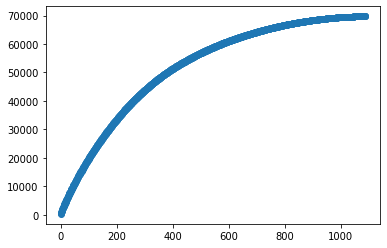

In [271]:
plt.figure(1)
plt.scatter(artist_count.artist_rank, artist_count.cumulative_songs)
plt.show()

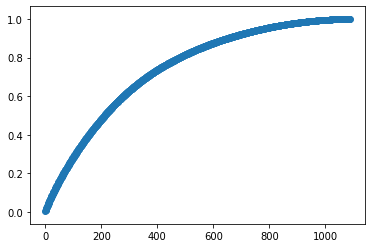

In [273]:
plt.figure(1)
plt.scatter(artist_count.artist_rank, artist_count.cumulative_song_pct)
plt.show()